Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Similarity Self-Supervised Learning Hello World

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

### Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to pre-train a `ContrastiveModel()` on the cifar100 dataset.

You are going to learn the main features offered by the `ContrastiveModel()` and will:

1. Create a `SingleShotMemorySampler()` that will generate two augmented views for each example in a batch.

2. Create basic versions of **Backbone**, **Projector**, and **Predictor** networks. These will be used to construct the `ContrastiveModel()`

3. Build a `ContrastiveModel()` using one of the three supported algorithms.

4. Compare the classification performance of training from scratch vs. using the frozen pre-trainined weights.

### Things to try

You can try the following things to improve the model performance:
- Try different self-supervised learning algorithms.
- Use a larger backbone model.
- Use a larger embedding by increasing the size of the projection and predictor layers.
- Try using other augmention functions.

In [2]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [6]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [7]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.6.0
TensorFlow Similarity 0.15.0.dev55


## Dataset Preperation

We are going to load the CIFAR100 dataset and partition the data into the following splits:
* **Train**: Data used for the pre-training and evaluation training phases.
* **Validation** Data used for validation metrics during the pre-training phase. 
* **Test** Data reserved for the evaluation tests.
* **Query and Index** Data used to compute matching metrics. The query data is used to retrieve the nearest indexed examples.

In [8]:
data_path = Path("../../kaggle_ds/google_landmarks")

### Loading

In [9]:
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [10]:
print(f"Class Names: {ds_info.features['label'].names}")

Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:20])  # 20 query examples per class
    index_idxs.extend(idxs[20:220])  # 200 index examples per class
    val_idxs.extend(idxs[220:260])  # 20 validation examples per class
    train_idxs.extend(idxs[260:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [12]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [13]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["test", x_test.shape, y_test.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples            Labels
-----  ------------------  --------
train  (47400, 32, 32, 3)  (47400,)
val    (400, 32, 32, 3)    (400,)
test   (10000, 32, 32, 3)  (10000,)
query  (200, 32, 32, 3)    (200,)
index  (2000, 32, 32, 3)   (2000,)


### Global Vars

In [14]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr"]

In [15]:
CIFAR_IMG_SIZE = 32
LARGER_IMG_SZ = int(1.2 * 32)

if ALGORITHM == "simsiam":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "barlow":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 100
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000  # we have 10k train steps and we warm up over 10% of that.
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "simclr":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 100
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.

## Single Shot DataSet

Self-supervised networks require two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as it's own class and then the augment function produces two separate views for each example. 

This means the resulting batch will yield tuples containing the two views, i.e., `Tuple[(BATCH_SIZE, 32, 32, 3), (BATCH_SIZE, 32, 32, 3)]`. 

TensorFlow Similarity provides several random augmentation functions, and here we are using the `SimCLRAugmenter()`. This augmenter returns values between [0, 1], but our ResNet backbone model expects the values to be between [0, 255] so we also scale the final output values in the augmentation function.

In [16]:
@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.
    
    The SimSiam augmentations are based on the SimCLR augmentations, but have 
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.
    
    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.
        
    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=area_range
    )
    img /= 255.0
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.simclr.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "simclrv2",
        )
    img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)
    
    # # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.simclr.to_grayscale(x)
    img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)
    
    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.simclr.random_blur(img, p=0.5)
        
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img


@tf.function()
def process(img):
    # SimClrAugmenter returns scaled values between [0,1]
    view1 = train_augmenter(img, blur=False)
    view2 = train_augmenter(img, blur=False)
    # The ResNet model scales internally and expects the inputs to be between [0, 255]
    return (view1 * 255.0, view2 * 255.0)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Visualize Batching

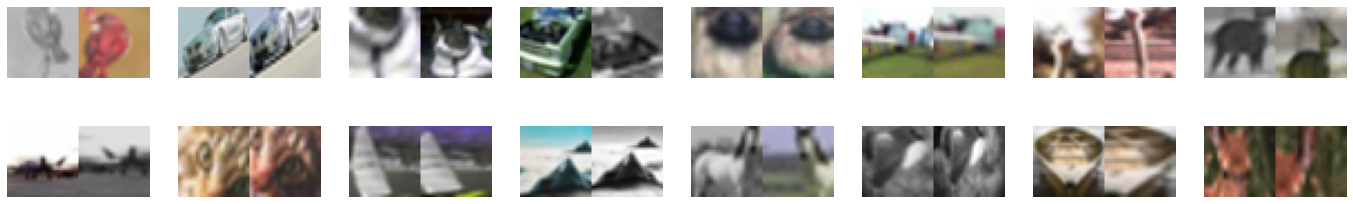

In [17]:
tfsim.visualization.visualize_views(
    views=next(train_ds.as_numpy_iterator()),
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=255.0,
)

## Models

There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.

Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. Several papers claim that the batch normalization is critical to prevent the model from colapsing to a degenerate solution.

### Backbone Model

Describe why we don't use ImageNet weights

In [18]:
def get_backbone(img_size, activation="relu", trainable=True):
    input_shape = (img_size, img_size, 3)
    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        augmentation=None,
        include_top=False,  # Take the pooling layer as the output.
        pooling="gem",  # Use GeneralizedMeanPooling2D
        gem_p=1.0,  # Increase the contrast between activations in the feature map.
        weight_decay=WEIGHT_DECAY,
        preproc_mode="torch",
    )
    return backbone


backbone = get_backbone(CIFAR_IMG_SIZE)
backbone.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
ResNet18 (Functional)        (None, 4, 4, 512)         11182784  
_________________________________________________________________
gem_pool (GeneralizedMeanPoo (None, 512)               0         
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


### Projector Model

In [19]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs
    k = 1.0 / dim

    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            name=f"projector_layer_{i}",
            kernel_initializer=tf.keras.initializers.RandomUniform(
                minval=-tf.math.sqrt(k), maxval=tf.math.sqrt(k)
            ),
            kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
        )(x)
        x = tf.keras.layers.BatchNormalization(
            epsilon=1.001e-5, name=f"batch_normalization_{i}"
        )(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
            x
        )
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        name="projector_output",
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-tf.math.sqrt(k), maxval=tf.math.sqrt(k)
        ),
        kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5, name=f"batch_normalization_ouput"
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
projector_input (InputLayer) [(None, 512)]             0         
_________________________________________________________________
projector_layer_0 (Dense)    (None, 2048)              1048576   
_________________________________________________________________
batch_normalization_0 (Batch (None, 2048)              8192      
_________________________________________________________________
relu_activation_0 (Activatio (None, 2048)              0         
_________________________________________________________________
projector_output (Dense)     (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_ouput (B (None, 2048)              8192      
_________________________________________________________________
proj_std (ActivationStdLoggi (None, 2048)              0 

### Predictor model

In [20]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs
    k = 1.0 / input_dim
    k_hidden = 1.0 / hidden_dim

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        name="predictor_layer_0",
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-tf.math.sqrt(k_hidden), maxval=tf.math.sqrt(k_hidden)
        ),
        kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5, name="batch_normalization_0"
    )(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-tf.math.sqrt(k), maxval=tf.math.sqrt(k)
        ),
        name="predictor_output",
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
predictor_input (InputLayer) [(None, 2048)]            0         
_________________________________________________________________
predictor_layer_0 (Dense)    (None, 512)               1048576   
_________________________________________________________________
batch_normalization_0 (Batch (None, 512)               2048      
_________________________________________________________________
relu_activation_0 (Activatio (None, 512)               0         
_________________________________________________________________
predictor_output (Dense)     (None, 2048)              1050624   
_________________________________________________________________
pred_std (ActivationStdLoggi (None, 2048)              0         
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
___________________________________________

## Self-Supervised Algorithms

In [21]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor,  # NOTE: simiam requires predictor model.
        algorithm=ALGORITHM,
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
    )
    lr_decayed_fn = tfsim.schedules.WarmUpCosine(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
        warmup_steps=WARMUP_STEPS,
        warmup_learning_rate=WARMUP_LR,
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm=ALGORITHM,
    )
    optimizer = tf.keras.optimizers.Adam(INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

### Compile

In [22]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

### Callbacks

In [23]:
log_dir = data_path / "models_owen" / "logs" / f"{loss.name}_{time.time()}"
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="loss", patience=50, restore_best_weights=True
# )
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
tsc = tfsim.callbacks.EvalCallback(
    tf.cast(x_query, tf.float32),
    y_query,
    tf.cast(x_index, tf.float32),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)
mcp_train = tf.keras.callbacks.ModelCheckpoint(
    filepath=data_path / "models_owen" / "checkpoints" / f"{loss.name}_{time.time()}",
    monitor="loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in ../../kaggle_ds/google_landmarks/models_owen/logs/simsiam_1639898867.826692/index


## Train

In [24]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[tsc, tbc,  mcp_train],
)

Epoch 1/800
92/92 [==============================] - 55s 510ms/step - contrastive_loss: 0.5243 - regularization_loss: 5.8123 - loss: 6.3365 - proj_std: 0.0202 - pred_std: 0.0172 - val_contrastive_loss: 0.3995 - val_regularization_loss: 5.6548 - val_loss: 6.0544 - val_proj_std: 0.0191 - val_pred_std: 0.0192
binary_accuracy: 0.1900
Epoch 2/800
92/92 [==============================] - 45s 486ms/step - contrastive_loss: 0.3284 - regularization_loss: 5.5029 - loss: 5.8313 - proj_std: 0.0204 - pred_std: 0.0191 - val_contrastive_loss: 0.2482 - val_regularization_loss: 5.3505 - val_loss: 5.5987 - val_proj_std: 0.0171 - val_pred_std: 0.0159
binary_accuracy: 0.2100
Epoch 3/800
92/92 [==============================] - 45s 486ms/step - contrastive_loss: 0.3032 - regularization_loss: 5.2068 - loss: 5.5100 - proj_std: 0.0204 - pred_std: 0.0193 - val_contrastive_loss: 0.2797 - val_regularization_loss: 5.0626 - val_loss: 5.3423 - val_proj_std: 0.0189 - val_pred_std: 0.0178
binary_accuracy: 0.2150
Epoc

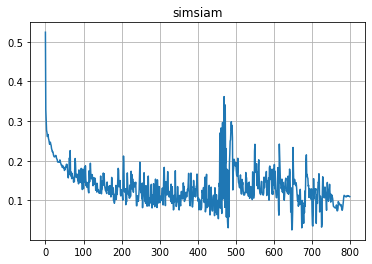

In [25]:
plt.plot(history.history["contrastive_loss"])
plt.grid()
plt.title(f'{loss.name} - contrastive loss')
plt.show()

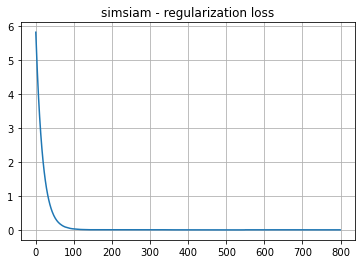

In [39]:
plt.plot(history.history["regularization_loss"])
plt.grid()
plt.title(f'{loss.name} - regularization loss')
plt.show()

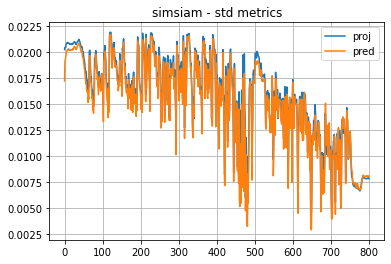

In [47]:
plt.plot(history.history["proj_std"], label='proj')
plt.plot(history.history["pred_std"], label='pred')
plt.grid()
plt.title(f'{loss.name} - std metrics')
plt.legend()
plt.show()

# Evaluation

In [26]:
TEST_EPOCHS = 10
TEST_STEPS_PER_EPOCH = int(len(x_train) // BATCH_SIZE)

In [31]:
@tf.function
def eval_augmenter(img):
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img

In [32]:
eval_train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.keras.utils.to_categorical(y_train, 10))
)
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(
    lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE
)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val, tf.keras.utils.to_categorical(y_val, 10))
)
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

eval_test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, tf.keras.utils.to_categorical(y_test, 10))
)
eval_test_ds = eval_test_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

In [33]:
def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(
        initial_learning_rate=lr, decay_steps=total_steps
    )
    opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model

## No Pretrain

In [34]:
no_pt_eval_model = get_eval_model(
    img_size=CIFAR_IMG_SIZE,
    backbone=get_backbone(CIFAR_IMG_SIZE, DIM),
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=True,
    lr=1e-3,
)
no_pt_history = no_pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
92/92 [==============================] - 24s 244ms/step - loss: 7.2792 - acc: 0.2303 - val_loss: 7.0293 - val_acc: 0.3346
Epoch 2/10
92/92 [==============================] - 22s 239ms/step - loss: 6.9962 - acc: 0.3220 - val_loss: 6.9171 - val_acc: 0.3808
Epoch 3/10
92/92 [==============================] - 22s 239ms/step - loss: 6.9049 - acc: 0.3586 - val_loss: 6.8427 - val_acc: 0.4062
Epoch 4/10
92/92 [==============================] - 22s 239ms/step - loss: 6.8425 - acc: 0.3760 - val_loss: 6.7941 - val_acc: 0.4282
Epoch 5/10
92/92 [==============================] - 22s 239ms/step - loss: 6.8032 - acc: 0.3915 - val_loss: 6.7763 - val_acc: 0.4282
Epoch 6/10
92/92 [==============================] - 22s 239ms/step - loss: 6.7673 - acc: 0.4021 - val_loss: 6.7336 - val_acc: 0.4329
Epoch 7/10
92/92 [==============================] - 22s 239ms/step - loss: 6.7552 - acc: 0.4072 - val_loss: 6.7354 - val_acc: 0.4245
Epoch 8/10
92/92 [==============================] - 22s 239ms/step - 

## Pretrained

In [35]:
pt_eval_model = get_eval_model(
    CIFAR_IMG_SIZE,
    contrastive_model.backbone,
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=False,
    lr=1.8,
)
pt_eval_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
eval_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
similarity_model (Similarity (None, 512)               11182784  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 11,187,914
Trainable params: 5,130
Non-trainable params: 11,182,784
_________________________________________________________________


In [36]:
pt_history = pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
92/92 [==============================] - 8s 73ms/step - loss: 675.2867 - acc: 0.1399 - val_loss: 410.3122 - val_acc: 0.1123
Epoch 2/10
92/92 [==============================] - 6s 69ms/step - loss: 608.4585 - acc: 0.1516 - val_loss: 554.2974 - val_acc: 0.1350
Epoch 3/10
92/92 [==============================] - 6s 69ms/step - loss: 443.9047 - acc: 0.1626 - val_loss: 499.4998 - val_acc: 0.2111
Epoch 4/10
92/92 [==============================] - 6s 69ms/step - loss: 328.8940 - acc: 0.1622 - val_loss: 263.3390 - val_acc: 0.1324
Epoch 5/10
92/92 [==============================] - 6s 69ms/step - loss: 205.1438 - acc: 0.1874 - val_loss: 192.6798 - val_acc: 0.1737
Epoch 6/10
92/92 [==============================] - 6s 69ms/step - loss: 108.0533 - acc: 0.2086 - val_loss: 106.8072 - val_acc: 0.2245
Epoch 7/10
92/92 [==============================] - 6s 69ms/step - loss: 64.7599 - acc: 0.2221 - val_loss: 75.4840 - val_acc: 0.2190
Epoch 8/10
92/92 [==============================] - 6s 69

## Comparison

In [37]:
# SimSiam
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 2s 75ms/step - loss: 6.6363 - acc: 0.4564
no pretrain [6.636349201202393, 0.4564000070095062]
20/20 [==============================] - 1s 55ms/step - loss: 21.9588 - acc: 0.3180
pretrained [21.95880699157715, 0.3179999887943268]


In [40]:
# SimCLR
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

40/40 [==============================] - 1s 34ms/step - loss: 1.4910 - acc: 0.6161
no pretrain [1.491011142730713, 0.616100013256073]
40/40 [==============================] - 1s 30ms/step - loss: 2.0020 - acc: 0.4137
pretrained [2.002046823501587, 0.41370001435279846]


In [53]:
# Barlow Pre-train Cifar 10 Linear classifier on Cifar 100
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 1s 32ms/step - loss: nan - acc: 0.1000
no pretrain [nan, 0.10000000149011612]
20/20 [==============================] - 1s 26ms/step - loss: 3.5400 - acc: 0.4260
pretrained [3.540032386779785, 0.4259999990463257]


In [63]:
# Barlow Pre-train Cifar 10 Linear classifier on Cifar 10
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 1s 32ms/step - loss: 2.5204 - acc: 0.3977
no pretrain [2.5204174518585205, 0.3977000117301941]
20/20 [==============================] - 1s 26ms/step - loss: 2.2891 - acc: 0.6451
pretrained [2.2890686988830566, 0.6450999975204468]
